In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import Any, Literal, Optional, Union

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)
from settings import refresh_settings  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


In [4]:
from instructor import AsyncInstructor

from schemas import GeneralResponse, ModelEnum
from utilities.client_utils import get_client

In [5]:
local_client: AsyncInstructor = get_client(is_remote=False)
remote_client: AsyncInstructor = get_client(is_remote=True)

Using mode: <Mode.JSON: 'json_mode'>
Using Ollama
Using mode: <Mode.JSON: 'json_mode'>
Using Remote


In [6]:
messages = [
    {
        "role": "assistant",
        "content": "/no_think You're an expert AI assstance that replies to questions. "
        "Your responses are returned in a string format only. ",
    },
    {
        "role": "user",
        "content": "Tell me briefly something unique about SF. ",
    },
]

response: GeneralResponse = await local_client.chat.completions.create(
    messages=messages,
    response_model=GeneralResponse,
    model=ModelEnum.BASE_MODEL_LOCAL_2.value,
    max_tokens=700,
    max_retries=3,
    temperature=0.0,
    seed=0,
)
console.log(response.content)

[22:58:10] San Francisco is known for its iconic Golden Gate Bridge, vibrant cultural scene, and   ]8;id=13463;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/2829152137.py\2829152137.py]8;;\:]8;id=550858;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/2829152137.py#22\22]8;;\
           the famous Alcatraz Island, which was a federal prison and now a tourist attraction.                    

In [7]:
response: GeneralResponse = await remote_client.chat.completions.create(
    messages=messages,
    response_model=GeneralResponse,
    model=ModelEnum.BASE_REMOTE_MODEL_1_7B.value,
    max_tokens=700,
    max_retries=3,
    temperature=0.0,
    seed=0,
)
console.log(response.content)

[22:58:14] San Francisco, known for its steep hills, fog, and diverse culture, is home to iconic    ]8;id=254253;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/318393952.py\318393952.py]8;;\:]8;id=917698;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/318393952.py#10\10]8;;\
           landmarks like the Golden Gate Bridge and Alcatraz Island. A unique aspect of SF is its                 
           vibrant tech industry, particularly in the Silicon Valley area, which has made it a                     
           global hub for innovation and entrepreneurship.                                                         

In [8]:
async def llm_response(
    message: str, client: AsyncInstructor, model: str, max_tokens: int = 1_000
) -> str:
    """
    Generate an AI response using the provided message and model parameters.

    Parameters
    ----------
    message : str
        The input message to send to the AI model.
    client : AsyncInstructor
        The async client instance for making API calls.
    model : str
        The name or identifier of the AI model to use.
    max_tokens : int, optional
        Maximum number of tokens in the response, by default 1,000.

    Returns
    -------
    str
        The generated AI response content.
    """
    response: GeneralResponse = await client.chat.completions.create(
        messages=[
            {
                "role": "assistant",
                "content": "<prompt>/no_think You're an expert AI assstance that "
                "replies to questions. Your responses are returned in a string format only. "
                "e.g. '</your_answer_here>' </prompt>",
            },
            {
                "role": "user",
                "content": f"<user>{message}</user>",
            },
        ],
        response_model=GeneralResponse,
        model=model,
        max_tokens=max_tokens,
        max_retries=3,
        temperature=0.0,
        seed=0,
    )

    return response.content

In [9]:
await llm_response(
    message="Tell me a joke about Cercei Lannister.",
    client=local_client,
    model=ModelEnum.BASE_MODEL_LOCAL_2.value,
)

"Why don't Lannisters ever get cold? Because they always wear multiple layers of 'I'm not a threat'!"

<hr>

### StateGraph

In [10]:
from typing import Annotated, TypedDict

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages

In [11]:
class State(TypedDict):
    # This appends messages instead of overwriting
    messages: Annotated[list, add_messages]


graph_builder: StateGraph = StateGraph(State)

In [12]:
nest_asyncio.apply()


def get_client_and_model() -> (
    tuple[Annotated[AsyncInstructor, "client"], Annotated[str, "model"]]
):
    """Get the local client and model configuration.

    Returns
    -------
    tuple[AsyncInstructor, str]
        A tuple containing:
        - client: The AsyncInstructor instance for local model interaction
        - model: The string identifier for the base local model
    """
    return local_client, ModelEnum.BASE_MODEL_LOCAL_2.value


# Add chatbot
async def chatbot(state: State) -> dict[str, Any]:
    """Process chat messages using an LLM model and return the response.

    Parameters
    ----------
    state : State
        The current state containing chat messages.

    Returns
    -------
    dict[str, Any]
        A dictionary containing the LLM response with key 'messages'.
    """
    client, model = get_client_and_model()
    response: str = await llm_response(state["messages"], client=client, model=model)
    return {"messages": response}


# (unique_name, function) when the node is called
graph_builder.add_node("chatbot", chatbot)

In [13]:
# Add entrypoint
graph_builder.add_edge(START, "chatbot")

# Compile graph
graph = graph_builder.compile()

## Visualize Graph

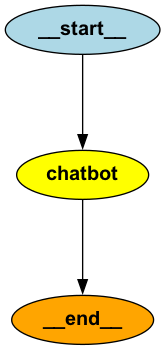

In [14]:
# uv add pygraphviz or pip install pygraphviz
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))

### Run The Graph

In [15]:
nest_asyncio.apply()


async def stream_graph_updates(user_input: str) -> None:
    """Process user input through a graph and stream assistant responses.

    This function takes a user input string and streams it through an async graph,
    printing the assistant's messages as they are generated.

    Parameters
    ----------
    user_input : str
        The input text from the user to process

    Returns
    -------
    None
        This function prints output but does not return any value
    """
    async for event in graph.astream(
        {"messages": [{"role": "user", "content": user_input}]}
    ):
        print(f"Assistant: {event['chatbot']['messages']}")

In [16]:
# Test user input
await stream_graph_updates(user_input="Tell me a joke about Cercei Lannister.")

Assistant: Why did Cercei Lannister bring a ladder to the wedding? Because she wanted to reach the top of the heap (a play on 'heap' meaning a pile of money or resources, and 'top of the heap' meaning the highest position or power).


In [ ]:
while True:
    try:
        user_input: str = input("User: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            break
        await stream_graph_updates(user_input)

    except Exception:
        # Fallback
        user_input = "Tell me a joke about Cercei Lannister."
        print(f"User: {user_input}")
        await stream_graph_updates(user_input)
        break

## Tool Use

In [17]:
from langchain_core.tools import tool
from tavily import TavilyClient


@tool("tavily_search")
def tavily_search(query: str) -> dict:
    """
    Search for information using the Tavily API.

    Parameters
    ----------
    query : str
        The search query string.

    Returns
    -------
    dict
        The search results from Tavily.
    """
    tavily_client = TavilyClient(api_key=settings.TAVILY_API_KEY.get_secret_value())
    return tavily_client.search(query)

In [ ]:
response = tavily_search("Who is Leo Messi?")
console.log(response)

In [ ]:
response["results"][0]

In [ ]:
local_client: AsyncInstructor = get_client(is_remote=False, mode="tool_mode")
remote_client: AsyncInstructor = get_client(is_remote=True, mode="tool_mode")

In [ ]:
await llm_response(
    "Who is Lionel Messi?",
    client=local_client,
    model=ModelEnum.BASE_MODEL_LOCAL_2.value,
)

In [38]:
import requests
from openai import AsyncOpenAI


def get_weather(latitude, longitude):
    response = requests.get(
        f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}"
        f"&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m"
    )
    data = response.json()
    return data["current"]["temperature_2m"]


remote_client: AsyncOpenAI = AsyncOpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
)
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_weather",
            "description": "Get current temperature for provided coordinates in celsius.",
            "parameters": {
                "type": "object",
                "properties": {
                    "latitude": {"type": "number"},
                    "longitude": {"type": "number"},
                },
                "required": ["latitude", "longitude"],
                "additionalProperties": False,
            },
            "strict": True,
        },
    }
]

messages = [
    {
        "role": "assistant",
        "content": "You're a worldclass AI assistant that answers users "
        "questions. You use the available tools to answer the questions. "
        "You only respond in a string format. e.g. '</your_answer_here>'",
    },
    {"role": "user", "content": "What is the weather like in Paris today?"},
]
response = await remote_client.chat.completions.create(
    model=ModelEnum.GPT_4_o_MINI_REMOTE.value,
    messages=messages,
    tools=tools,
    temperature=0.0,
    seed=0,
)

In [39]:
console.log(response.choices[0].message)

[23:15:39] ChatCompletionMessage(                                                                   ]8;id=939461;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/4258338503.py\4258338503.py]8;;\:]8;id=589963;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/4258338503.py#1\1]8;;\
               content='',                                                                                         
               refusal=None,                                                                                       
               role='assistant',                                                                                   
               annotations=None,                                                                                   
               audio=None,                                                                                         
               function_call=None,                                                                                 
               tool_calls=[                                                                                        
                   ChatCompletionMessageToolCall(                                                                  
                       id='call_ZQaBINkMdPUN3aFMCB0grFNW',                                                         
                       function=Function(                                                                          
                           arguments='{"latitude":48.8566,"longitude":2.3522}',                                    
                           name='get_weather'                                                                      
                       ),                                                                                          
                       type='function',                                                                            
                       index=0                                                                                     
                   )                                                                                               
               ],                                                                                                  
               reasoning=None                                                                                      
           )                                                                                                       

In [40]:
# Step 2
tool_call = response.choices[0].message.tool_calls[0]
args = json.loads(tool_call.function.arguments)

result = get_weather(args["latitude"], args["longitude"])
console.log(result)

# Step 3
messages.append(response.choices[0].message)  # append model's function call message
messages.append(
    {  # append result message
        "role": "tool",
        "tool_call_id": tool_call.id,
        "content": str(result),
    }
)

# Step 4
response_2 = await remote_client.chat.completions.create(
    model=ModelEnum.GPT_4_o_MINI_REMOTE.value,
    messages=messages,
    tools=tools,
)
console.log(response_2)

[23:15:47] 15.6                                                                                     ]8;id=986878;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/3472273555.py\3472273555.py]8;;\:]8;id=600559;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/3472273555.py#6\6]8;;\

[23:15:48] ChatCompletion(                                                                         ]8;id=812609;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/3472273555.py\3472273555.py]8;;\:]8;id=413808;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_87067/3472273555.py#24\24]8;;\
               id='gen-1747174548-uMlFO68I2blW50OiCooy',                                                           
               choices=[                                                                                           
                   Choice(                                                                                         
                       finish_reason='stop',                                                                       
                       index=0,                                                                                    
                       logprobs=None,                                                                              
                       message=ChatCompletionMessage(                                                              
                           content="'The current temperature in Paris today is 15.6°C.'",                          
                           refusal=None,                                                                           
                           role='assistant',                                                                       
                           annotations=None,                                                                       
                           audio=None,                                                                             
                           function_call=None,                                                                     
                           tool_calls=None,                                                                        
                           reasoning=None                                                                          
                       ),                                                                                          
                       native_finish_reason='stop'                                                                 
                   )                                                                                               
               ],                                                                                                  
               created=1747174548,                                                                                 
               model='openai/gpt-4o-mini',                                                                         
               object='chat.completion',                                                                           
               service_tier=None,                                                                                  
               system_fingerprint='fp_dbaca60df0',                                                                 
               usage=CompletionUsage(                                                                              
                   completion_tokens=16,                                                                           
                   prompt_tokens=136,                                                                              
                   total_tokens=152,                                                                               
                   completion_tokens_details=CompletionTokensDetails(                                              
                       accepted_prediction_tokens=None,                                                            
                       audio_tokens=None,                                                                          
                       reasoning_tokens=0,                           

In [ ]:
console.log(response)

In [ ]:
from ollama import ChatResponse, chat


def add_two_numbers(a: int, b: int) -> int:
    """
    Add two numbers

    Args:
      a (int): The first number
      b (int): The second number

    Returns:
      int: The sum of the two numbers
    """

    # The cast is necessary as returned tool call arguments don't always conform exactly to schema
    # E.g. this would prevent "what is 30 + 12" to produce '3012' instead of 42
    return int(a) + int(b)


def subtract_two_numbers(a: int, b: int) -> int:
    """
    Subtract two numbers
    """

    # The cast is necessary as returned tool call arguments don't always conform exactly to schema
    return int(a) - int(b)


# Tools can still be manually defined and passed into chat
subtract_two_numbers_tool = {
    "type": "function",
    "function": {
        "name": "subtract_two_numbers",
        "description": "Subtract two numbers",
        "parameters": {
            "type": "object",
            "required": ["a", "b"],
            "properties": {
                "a": {"type": "integer", "description": "The first number"},
                "b": {"type": "integer", "description": "The second number"},
            },
        },
    },
}

messages = [{"role": "user", "content": "<user>What is three plus one?</user>"}]
print("Prompt:", messages[0]["content"])

available_functions = {
    "add_two_numbers": add_two_numbers,
    "subtract_two_numbers": subtract_two_numbers,
}

response: ChatResponse = chat(
    ModelEnum.BASE_MODEL_LOCAL_2.value,
    messages=messages,
    tools=[add_two_numbers, subtract_two_numbers_tool],
)

if response.message.tool_calls:
    # There may be multiple tool calls in the response
    for tool in response.message.tool_calls:
        # Ensure the function is available, and then call it
        if function_to_call := available_functions.get(tool.function.name):
            print("Calling function:", tool.function.name)
            print("Arguments:", tool.function.arguments)
            output = function_to_call(**tool.function.arguments)
            print("Function output:", output)
        else:
            print("Function", tool.function.name, "not found")

# Only needed to chat with the model using the tool call results
if response.message.tool_calls:
    # Add the function response to messages for the model to use
    messages.append(response.message)
    messages.append({"role": "tool", "content": str(output), "name": tool.function.name})

    # Get final response from model with function outputs
    final_response = chat(ModelEnum.BASE_MODEL_LOCAL_2.value, messages=messages)
    print("Final response:", final_response.message.content)

else:
    print("No tool calls returned from model")

In [ ]:
response = await remote_client.chat.completions.create(
    response_model=GeneralResponse,
    messages=[{"role": "user", "content": "What is seven plus twelve?"}],
    model=ModelEnum.BASE_REMOTE_MODEL_2_8B.value,
    tools=[add_two_numbers, subtract_two_numbers],
)